In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import os

current_palette = sns.color_palette()
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

sns.set(rc={'figure.figsize':(10,4)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def save_fig(ax, folder, suffix, format="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()

    fig.savefig(folder + suffix + "." + format)
    fig.clear()

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
locations = pd.read_csv("locations.csv")

In [47]:
# we only care about 15 minutes of the experiment
# also we want to offset the start time by another 5 minutes (ramp up)
# convert to milliseconds
experiment_duration = 15 * 60 * 1e3
start_offset = 5 * 60 * 1e3

In [48]:
df_experiment = pd.DataFrame()
all_dfs = []

for run_name in ["cloud", "sat"]:
    for run_number in ["1", "2", "3"]:

        results_dir = os.path.join(".", "results", f"results-{run_name}-{run_number}")
        files = os.listdir(os.path.join(".", results_dir))

        # first we find out the start time of the experiment
        # the actual start time is the latest "first" entry in all of the files
        start_time = 0
        for f in files:
            with open(os.path.join(".", results_dir, f)) as fp:
                # get an iterator
                lines = iter(fp)
                # skip the first line
                next(lines)
                # split the first data line and
                # get send_time_1
                send_time_1 = int(next(lines).split(",")[4])

                if send_time_1 > start_time:
                    start_time = send_time_1

        # convert start_time to milliseconds
        start_time = start_time / 1e6
        start_time += start_offset

        for f in files:

            try:
                client = f[len("cesink"):-len(".ext4-results.csv")]

                df_run = pd.read_csv(os.path.join(".", results_dir, f))
                df_run["client"] = client
                df_run["run_name"] = run_name
                df_run["run_number"] = run_number

                # convert to milliseconds
                df_run["send_time1"] = df_run["send_time1"] / 1e6
                df_run["send_time2"] = df_run["send_time2"] / 1e6
                df_run["recv_time1"] = df_run["recv_time1"] / 1e6
                df_run["recv_time2"] = df_run["recv_time2"] / 1e6

                # now we need to filter out by start_time and duration
                # consider send_time_1 for this
                df_run = df_run[(df_run["send_time1"] >= start_time) & (df_run["send_time1"] <= start_time + experiment_duration)]
                df_run.reset_index(inplace=True)

                df_run["send_latency1"] = df_run["recv_time1"] - df_run["send_time1"]
                df_run["send_latency2"] = df_run["recv_time2"] - df_run["send_time2"]
                df_run["processing_latency"] = df_run["send_time2"] - df_run["recv_time1"]
                df_run["total_latency"] = df_run["recv_time2"] - df_run["send_time1"]

                df_run["latency"] = df_run["recv_time2"] - df_run["send_time1"]

                # print(locations.loc[locations["id"] == client, "lat"].values[0])

                all_dfs.append(df_run)

                df_experiment = df_experiment.append(pd.DataFrame({
                    "client": client,
                    "run_name": run_name,
                    "run_number": run_number,
                    "lat": locations.loc[locations["id"] == client, "lat"].values[0],
                    "lng": locations.loc[locations["id"] == client, "lng"].values[0],
                    "mean_send_latency1": df_run["send_latency1"].mean(),
                    "mean_send_latency2": df_run["send_latency2"].mean(),
                    "mean_processing_latency": df_run["processing_latency"].mean(),
                    "mean_total_latency": df_run["total_latency"].mean(),
                    "median_send_latency1": df_run["send_latency1"].median(),
                    "median_send_latency2": df_run["send_latency2"].median(),
                    "median_processing_latency": df_run["processing_latency"].median(),
                    "median_total_latency": df_run["total_latency"].median(),
                    "max_send_latency1": df_run["send_latency1"].max(),
                    "max_send_latency2": df_run["send_latency2"].max(),
                    "max_processing_latency": df_run["processing_latency"].max(),
                    "max_total_latency": df_run["total_latency"].max(),
                    "99th_send_latency1": df_run["send_latency1"].quantile(0.99),
                    "99th_send_latency2": df_run["send_latency2"].quantile(0.99),
                    "99th_processing_latency": df_run["processing_latency"].quantile(0.99),
                    "99th_total_latency": df_run["total_latency"].quantile(0.99),
                    "95th_send_latency1": df_run["send_latency1"].quantile(0.95),
                    "95th_send_latency2": df_run["send_latency2"].quantile(0.95),
                    "95th_processing_latency": df_run["processing_latency"].quantile(0.95),
                    "95th_total_latency": df_run["total_latency"].quantile(0.95),
                }, index=[0]))

            except Exception as e:
                print(f"Error reading file {f}")
                raise e

df_complete = pd.concat(all_dfs)
df_complete.dropna(inplace=True)
df_complete.reset_index(inplace=True)

df_experiment.dropna(inplace=True)
df_experiment.reset_index(inplace=True)

df_experiment

KeyboardInterrupt: 

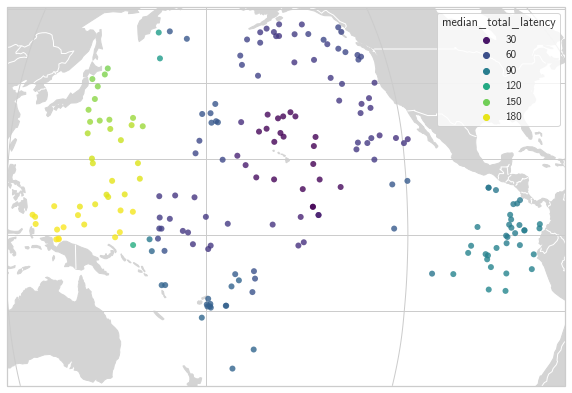

In [ ]:
cmap = sns.color_palette("viridis", as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=df_experiment[(df_experiment["run_name"] == "cloud") & (df_experiment["run_number"] == "2")], x="lng", y="lat", transform=ccrs.PlateCarree(), palette=cmap, zorder=10, linewidth=0, alpha=0.8, hue="median_total_latency")

plt.show()

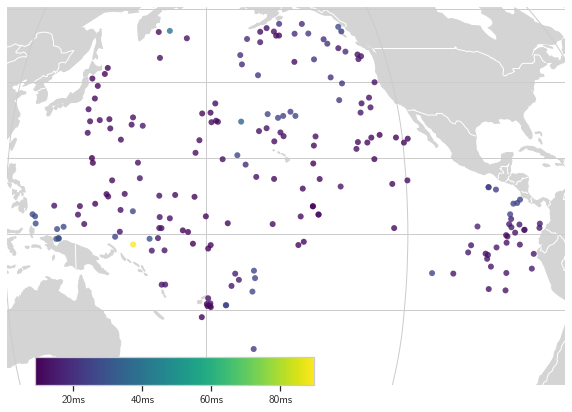

In [ ]:
cmap = sns.color_palette("viridis", as_cmap=True)
df = df_experiment[(df_experiment["run_name"] == "sat") & (df_experiment["run_number"] == "1")]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=df, x="lng", y="lat", transform=ccrs.PlateCarree(), palette=cmap, zorder=10, linewidth=0, alpha=0.8, hue="median_total_latency")

norm = plt.Normalize(max(df["median_total_latency"]), min(df["median_total_latency"]))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax.get_legend().remove()
cbar = ax.figure.colorbar(sm, location='bottom', shrink=0.5, pad=-0.15, aspect=10, anchor=(0.1, 0))
cbar.ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%dms'))
ax.axis('off')

plt.show()

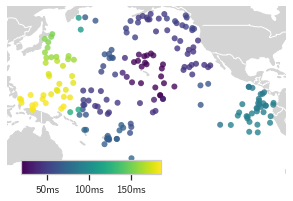

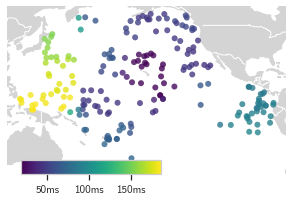

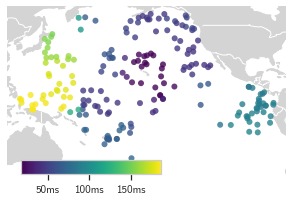

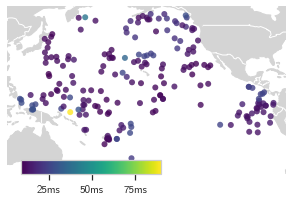

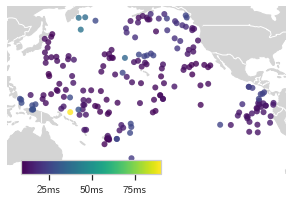

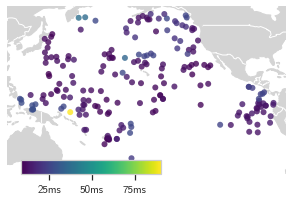

In [ ]:
cmap = sns.color_palette("viridis", as_cmap=True)

def make_map(df, name):
    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))
    ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
    # ax.set_extent ((-7.5, 40, 33, 59), cartopy.crs.PlateCarree())
    sns.scatterplot(ax=ax, data=df, x="lng", y="lat",hue="median_total_latency", palette=cmap, transform=ccrs.Geodetic(), zorder=10, linewidth=0, alpha=0.8)

    norm = plt.Normalize(max(df["median_total_latency"]), min(df["median_total_latency"]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    cbar = ax.figure.colorbar(sm, location='bottom', shrink=0.5, pad=-0.15, aspect=10, anchor=(0.1, 0))
    cbar.ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%dms'))
    ax.axis('off')
    plt.show()
    #save_fig(ax=ax, folder="", suffix=name, format="pdf")f
for name in ["cloud", "sat"]:
    for run in ["1", "2", "3"]:
        make_map(df_experiment[ (df_experiment["run_name"] == name) &(df_experiment["run_number"] == run)], f"{name}_{run}")

In [ ]:
df_complete

,level_0,index,sensor_id,service_id,packet_n,packet_len,send_time1,recv_time1,send_time2,recv_time2,client,run_name,run_number,send_latency1,send_latency2,processing_latency,total_latency,latency
0,0,289,55.0,hawaii.gst.celestial,16.0,81.0,1.646567e+12,1.646567e+12,1.646567e+12,1.646567e+12,S163,cloud,1,26.408691,27.089355,0.775635,54.273682,54.273682
1,1,290,97.0,hawaii.gst.celestial,22.0,81.0,1.646567e+12,1.646567e+12,1.646567e+12,1.646567e+12,S163,cloud,1,0.884277,26.951172,1.773193,29.608643,29.608643
2,2,291,175.0,hawaii.gst.celestial,22.0,82.0,1.646567e+12,1.646567e+12,1.646567e+12,1.646567e+12,S163,cloud,1,0.590332,27.085205,0.862305,28.537842,28.537842
3,3,292,86.0,hawaii.gst.celestial,19.0,81.0,1.646567e+12,1.646567e+12,1.646567e+12,1.646567e+12,S163,cloud,1,33.905029,27.246582,0.870850,62.022461,62.022461
4,4,293,44.0,hawaii.gst.celestial,19.0,81.0,1.646567e+12,1.646567e+12,1.646567e+12,1.646567e+12,S163,cloud,1,34.634033,27.295410,0.994141,62.923584,62.923584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9298674,7016,7046,188.0,62.0.celestial,1410.0,77.0,1.646565e+12,1.646565e+12,1.646565e+12,1.646565e+12,I434,sat,3,5.829590,5.325439,0.864258,12.019287,12.019287
9298675,7017,7047,173.0,62.0.celestial,1406.0,77.0,1.646565e+12,1.646565e+12,1.646565e+12,1.646565e+12,I434,sat,3,7.208984,5.226562,1.115967,13.551514,13.551514
9298676,7018,7048,138.0,62.0.celestial,1409.0,77.0,1.646565e+12,1.646565e+12,1.646565e+12,1.646565e+12,I434,sat,3,5.077393,4.908691,1.130615,11.116699,11.116699
9298677,7019,7049,135.0,62.0.celestial,1409.0,77.0,1.646565e+12,1.646565e+12,1.646565e+12,1.646565e+12,I434,sat,3,5.707520,4.966064,1.081055,11.754639,11.754639


In [ ]:
test_df_cloud = df_complete[(df_complete["run_name"] == "cloud") & (df_complete["run_number"] == "2")]
test_df_sat = df_complete[(df_complete["run_name"] == "sat") & (df_complete["run_number"] == "2")]

In [ ]:
test_df_cloud

,level_0,index,sensor_id,service_id,packet_n,packet_len,send_time1,recv_time1,send_time2,recv_time2,client,run_name,run_number,send_latency1,send_latency2,processing_latency,total_latency,latency
1548790,0,294,54.0,hawaii.gst.celestial,23.0,81.0,1.646569e+12,1.646569e+12,1.646569e+12,1.646569e+12,S163,cloud,2,0.551270,27.415527,1.332520,29.299316,29.299316
1548791,1,295,74.0,hawaii.gst.celestial,23.0,81.0,1.646569e+12,1.646569e+12,1.646569e+12,1.646569e+12,S163,cloud,2,0.834717,27.276123,1.242432,29.353271,29.353271
1548792,2,296,86.0,hawaii.gst.celestial,23.0,81.0,1.646569e+12,1.646569e+12,1.646569e+12,1.646569e+12,S163,cloud,2,33.676270,27.289551,1.202148,62.167969,62.167969
1548793,3,297,37.0,hawaii.gst.celestial,17.0,81.0,1.646569e+12,1.646569e+12,1.646569e+12,1.646569e+12,S163,cloud,2,35.289062,27.380127,1.490234,64.159424,64.159424
1548794,4,298,44.0,hawaii.gst.celestial,22.0,81.0,1.646569e+12,1.646569e+12,1.646569e+12,1.646569e+12,S163,cloud,2,34.693359,27.277344,1.240479,63.211182,63.211182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097851,7019,7089,135.0,hawaii.gst.celestial,1425.0,83.0,1.646570e+12,1.646570e+12,1.646570e+12,1.646570e+12,I434,cloud,2,87.549805,87.846436,0.940430,176.336670,176.336670
3097852,7020,7090,137.0,hawaii.gst.celestial,1427.0,83.0,1.646570e+12,1.646570e+12,1.646570e+12,1.646570e+12,I434,cloud,2,87.731934,87.891113,1.102783,176.725830,176.725830
3097853,7021,7091,188.0,hawaii.gst.celestial,1419.0,83.0,1.646570e+12,1.646570e+12,1.646570e+12,1.646570e+12,I434,cloud,2,89.076904,88.531494,1.076416,178.684814,178.684814
3097854,7022,7092,173.0,hawaii.gst.celestial,1421.0,83.0,1.646570e+12,1.646570e+12,1.646570e+12,1.646570e+12,I434,cloud,2,87.644287,88.024658,1.024902,176.693848,176.693848


<AxesSubplot:xlabel='processing_latency', ylabel='Count'>

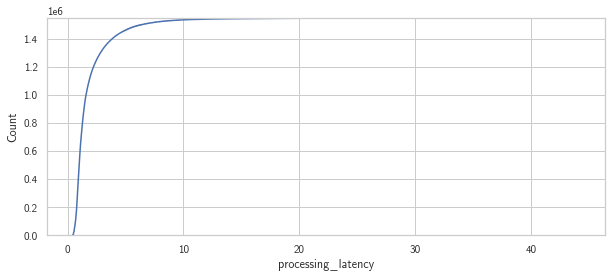

In [ ]:
sns.ecdfplot(data=test_df_cloud, x="processing_latency", stat="count")

<AxesSubplot:xlabel='processing_latency', ylabel='Proportion'>

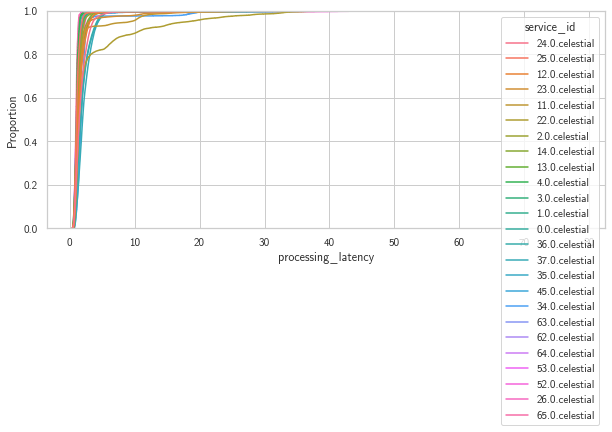

In [ ]:
sns.ecdfplot(data=test_df_sat, x="processing_latency", hue="service_id")

<AxesSubplot:xlabel='sensor_id', ylabel='count'>

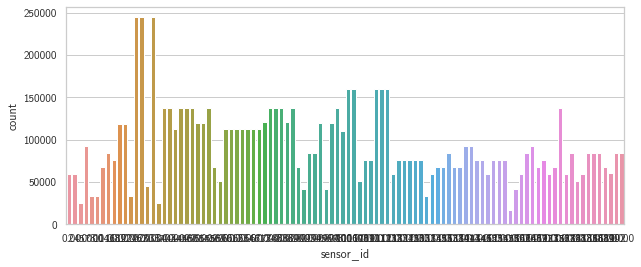

In [ ]:
sns.countplot(data=df_complete, x="sensor_id")